In [1]:
import pickle  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import sys, os
import warnings
  
from rdkit import Chem  
from rdkit.Chem import PandasTools  
from rdkit.Chem import AllChem  
from rdkit.Chem import Descriptors  
from rdkit.Chem import rdMolDescriptors  
from rdkit.Chem.Draw import IPythonConsole  
from rdkit.Chem import Draw  
from rdkit import DataStructs  
from rdkit.Chem.Draw import rdMolDraw2D  
  
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error  
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler  
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 

from xgboost import XGBRegressor   
import xgboost as xgb  

from math import sqrt  
import shap
import matplotlib.pyplot as plt  

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
Dataset = pd.read_excel('./FFV.xlsx')

In [3]:
RepeatUnits = Dataset.iloc[:, [1]]
Polymers = RepeatUnits.iloc[:, 0].apply(Chem.MolFromSmiles)
RepeatUnits.loc[:,['Polymers']] = Polymers
RepeatUnits = RepeatUnits.dropna()

fp = Polymers.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_n = fp.apply(lambda m: m.GetNonzeroElements())

In [4]:
HashCode = []
for i in fp_n:
    for j in i.keys():
        HashCode.append(j)
        
unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

In [5]:
MY_finger = []
for polymer in fp_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)
    
MY_finger_dataset = pd.DataFrame(MY_finger)  

In [6]:
Zero_Sum = (MY_finger_dataset == 0).astype(int).sum()
NumberOfZero = 7900
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X = MY_finger_dataset[Zero_Sum[Zero_Sum < NumberOfZero].index]

425


In [7]:
Y = np.array(list(Dataset['FFV']) )

In [8]:
scaler = StandardScaler()
Y = scaler.fit_transform(Y.reshape(-1,1))

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=26)  
model = XGBRegressor(n_estimators=180, max_depth=14, learning_rate=0.08, subsample=0.81, colsample_bytree=0.8, gamma=0, random_state=26)  
model.fit(x_train, y_train)  

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
y_pred_train = model.predict((x_train))
y_pred_train = scaler.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test = model.predict((x_test))
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1,1))

print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.3f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.3f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Train MSE score: %.3f" % mean_squared_error(y_train, y_pred_train))

print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.3f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test MSE score: %.3f" % mean_squared_error(y_test, y_pred_test))

Train set R^2: 1.00
Train MAE score: 0.001
Train RMSE score: 0.002
Train MSE score: 0.000
Test set R^2: 0.88
Test MAE score: 0.006
Test RMSE score: 0.010
Test MSE score: 0.000


In [10]:
# cv_scores = cross_val_score(model, X, Y, cv=10, scoring='r2')  
# print("CV R^2:", cv_scores)  
# print("AVR R^2:", np.mean(cv_scores))

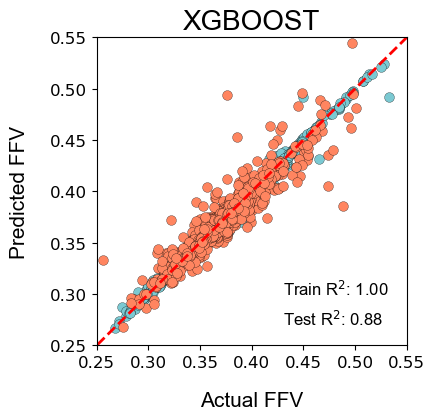

In [41]:
plt.figure(figsize=(4, 4))
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.scatter(y_train, y_pred_train, c='#7bc9d2',  s=50, edgecolors='k', linewidths=0.2)   
plt.scatter(y_test, y_pred_test, c='#ff8560', marker='o', s=50, edgecolors='k', linewidths=0.2)  
plt.xlabel("Actual FFV", labelpad=15, fontname="Arial", fontsize=15)  
plt.ylabel("Predicted FFV", labelpad=15, fontname="Arial", fontsize=15)   
plt.plot([0.2, 0.8], [0.2, 0.8], 'r--', linewidth=2)  
plt.title('XGBOOST', fontname="Arial", fontsize=20)  
plt.text(0.43, 0.30, "Train R$^2$: %.2f" % r2_score(y_train, y_pred_train), fontname="Arial", fontsize=12) 
plt.text(0.43, 0.27, "Test R$^2$: %.2f" % r2_score(y_test, y_pred_test), fontname="Arial", fontsize=12)  
plt.xlim(0.25, 0.55) 
plt.ylim(0.25, 0.55) 
plt.show()  

[17:39:40] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:39:41] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 8023/8046 [02:17<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


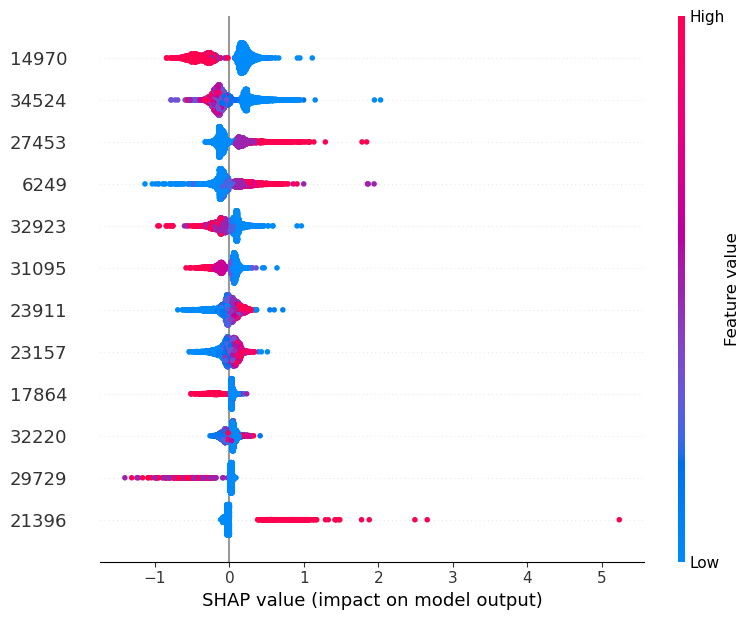

In [13]:
explainer = shap.Explainer(model, X)
shap_values = explainer.shap_values(X)